/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Norm stats (0.4550425537458112, 0.4452370645841326)
torch.Size([2, 9, 120, 120])


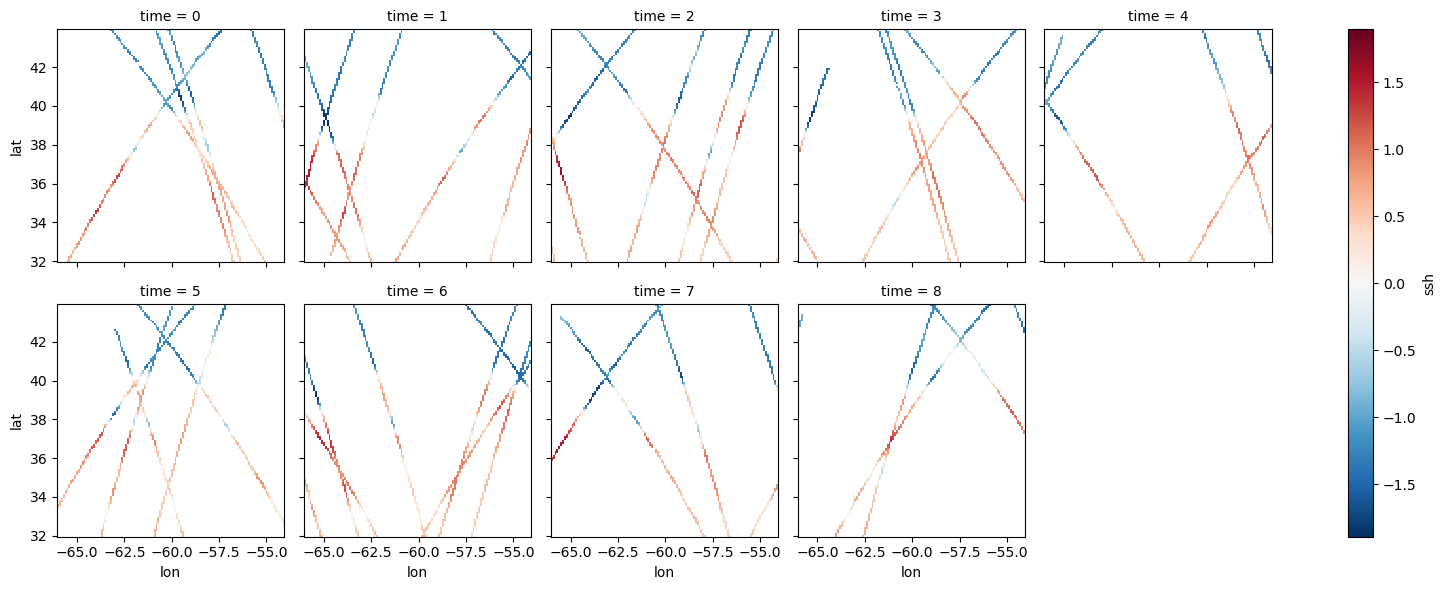

In [1]:
import sys
sys.path.append('..')
from src.data_notebook import *
from src.utils import *
from src.models import *
from contrib.stoch_spde.lit_model_spde import *
from contrib.stoch_spde.models_spde import *
#from contrib.stoch_spde.solver import *
#from contrib.stoch_spde.unet import *

def spspmm(A,B):
    return torch.sparse.mm(A,B)

import matplotlib.pyplot as plt
import torch
import itertools

lon_min = -66 
lon_max = -54
#lon_max = -63
lat_min = 32
lat_max = 44
#lat_max = 35

datamodule = BaseDataModule(input_da=load_altimetry_data_ose("/DATASET/mbeauchamp/natl_ose_6nadirs.nc"),
                            domains={'train': {'time': slice('2017-01-01', '2017-10-31',)},
                                     'val': {'time': slice('2017-11-01', '2017-11-30',)},
                                     'test': {'time': slice('2017-12-01', '2017-12-31',)}},
                            xrds_kw={'patch_dims': {'time': 9, 'lat': 120, 'lon': 120},
                                     'strides': {'time': 1, 'lat': 120, 'lon': 120},
                                     'domain_limits':  dict(lon=slice(lon_min, lon_max,),
                                                            lat=slice(lat_min, lat_max,))},
                            dl_kw={'batch_size': 2, 'num_workers': 1},
                            aug_kw={'aug_factor': 1, 'aug_only': True},
                            resize_factor=2, grad=False)
datamodule.setup()


# datamodule.train_ds[0].input has shape (15, 240, 240)
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),datamodule.train_ds[0].tgt)},
           coords={'time':np.arange(9),
                   'lon':np.arange(lon_min, lon_max, 0.1),
                   'lat':np.arange(lat_min, lat_max, 0.1)}).ssh.plot(col='time',col_wrap=5)

data_loader = datamodule.train_dataloader()
k=10
my_sample = next(itertools.islice(data_loader, k, None))
print(my_sample[0].shape)

# Define the solver

In [5]:
### import pandas as pd
import einops
from pathlib import Path
import pytorch_lightning as pl
import kornia.filters as kfilts
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import xarray as xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GradSolver_Lgv(nn.Module):
    def __init__(self, nll, nlpobs, prior_cost, obs_cost, grad_mod, n_step,
                 lr_grad=0.2, exclude_params=False, aug_state=True,  unet_prior=False, **kwargs):
        super().__init__()
        self.nll = nll
        self.nlpobs = nlpobs
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.unet_prior = unet_prior
        self.grad_mod = grad_mod
        self.n_step = n_step
        self.lr_grad = lr_grad
        self.exclude_params = exclude_params
        self._grad_norm = None
        self.aug_state = aug_state
        self.lambda_obs = torch.nn.Parameter(torch.Tensor([1.]))
        self.lambda_reg = torch.nn.Parameter(torch.Tensor([1.]))

        self.downsamp = 2#self.nll.downsamp
        self.down = nn.AvgPool2d(self.downsamp) if self.downsamp is not None else nn.Identity()
        
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=self.downsamp)
            #Upsampler(scale_factor=self.downsamp,
            #         mode='bilinear',
            #         align_corners=False,
            #         antialias=True)
            if self.downsamp is not None
            else nn.Identity()
        )
    def custom_sigmoid(self,x,min,max):
        add_const = min/(max-min)
        mult_const = max-min
        return (torch.sigmoid(x)+add_const)*mult_const

    def interpolate_na_2D(self, da, max_value=100.):
        return (
            da.where(np.abs(da) < max_value, np.nan)
            .pipe(lambda da: da)
            .to_dataframe()
            .interpolate(limit_direction='both')
            .pipe(xr.Dataset.from_dataframe)
        )

    def init_fields(self, obs):
        n_b, n_t, n_y, n_x = obs.shape
        y_xr = xr.Dataset(data_vars={'ssh':(('batch','time','lat','lon'),obs.detach().cpu())},
                      coords={'batch':np.arange(n_b),
                              'time':np.arange(n_t),
                              'lon':np.arange(n_x),
                              'lat':np.arange(n_y)})
        ybis =  self.interpolate_na_2D(y_xr.mean(dim='time'))
        ybis =  ybis.coarsen(lon=4, boundary="trim").mean().coarsen(lat=4, boundary="trim").mean()
        ybis = einops.repeat(torch.tensor(ybis.ssh.data), 'b m n -> b k m n', k=5)
        m = torch.nn.Upsample(scale_factor=4, mode='bilinear')  # align_corners=False
        ybis = m(ybis)
        qg_veloc = kfilts.spatial_gradient(ybis,normalized=True)
        qg_veloc = torch.permute(qg_veloc,(0,2,1,3,4))
        return qg_veloc
    
    def init_state(self, batch, x_init=None):
        
        if self.aug_state==False:
            if x_init is not None:
                return x_init
            else:
                return batch.input.nan_to_num().detach().requires_grad_(True)        
        else:
            #qg_veloc = self.init_fields(batch.input.detach()).to(device)
            #m1_init = qg_veloc[:,0,:,:,:]
            #m2_init = qg_veloc[:,1,:,:,:]
            kappa_init = torch.sum(torch.abs(kfilts.spatial_gradient(x_init,normalized=True)),dim=2)
            kappa_init = torch.max(kappa_init)-kappa_init+.01
            tau_init = torch.sum(torch.abs(kfilts.spatial_gradient(x_init,normalized=True)),dim=2)+.01
            m1_init = kfilts.spatial_gradient(x_init,normalized=True)[:,:,0,:,:]
            m2_init = kfilts.spatial_gradient(x_init,normalized=True)[:,:,1,:,:]
            vx_init = kfilts.spatial_gradient(x_init,order=1,normalized=True)[:,:,0,:,:]
            vy_init = kfilts.spatial_gradient(x_init,order=1,normalized=True)[:,:,1,:,:]
            gamma_init = torch.ones(batch.input.size()).to(device)
            beta_init = torch.ones(batch.input.size()).to(device)
            '''
            kappa_init = torch.ones(batch.input.size()).to(device)*0.1
            tau_init = torch.ones(batch.input.size()).to(device)*1
            m1_init = torch.ones(batch.input.size()).to(device)*0.1
            m2_init = torch.ones(batch.input.size()).to(device)*0.1
            vx_init = torch.zeros(batch.input.size()).to(device)
            vy_init = torch.zeros(batch.input.size()).to(device)
            gamma_init = torch.ones(batch.input.size()).to(device)
            beta_init = torch.ones(batch.input.size()).to(device)
            '''
            """       
            H = []
            for k in range(n_t):
                vx_ = torch.reshape(vx_init[:,k,:,:],(n_b,n_x*n_y))
                vy_ = torch.reshape(vy_init[:,k,:,:],(n_b,n_x*n_y))
                vxy = torch.stack([vx_,vy_],dim=2)
                vxyT = torch.permute(vxy,(0,2,1))
                gamma_ = torch.reshape(gamma_init[:,k,:,:],(n_b,n_x*n_y))
                beta_ = torch.reshape(beta_init[:,k,:,:],(n_b,n_x*n_y))
                H_ = torch.einsum('ij,bk->bijk',
                              torch.eye(2).to(device),
                              gamma_)+\
                 torch.einsum('bk,bijk->bijk',beta_,torch.einsum('bki,bjk->bijk',vxy,vxyT))
                H.append(H_)
            H = torch.stack(H,dim=4)

            xr.Dataset(data_vars={'H11':(('time','lat','lon'),np.reshape(H[0,0,0,:,:9].t().detach().cpu(),(9,120,120)))},
                   coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H11.plot(col='time')
            plt.show()     
            xr.Dataset(data_vars={'H12':(('time','lat','lon'),np.reshape(H[0,0,1,:,:9].t().detach().cpu(),(9,120,120)))},
                   coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H12.plot(col='time')
            plt.show()   
            xr.Dataset(data_vars={'H21':(('time','lat','lon'),np.reshape(H[0,1,0,:,:9].t().detach().cpu(),(9,120,120)))},
                   coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H21.plot(col='time')
            plt.show()   
            xr.Dataset(data_vars={'H22':(('time','lat','lon'),np.reshape(H[0,1,1,:,:9].t().detach().cpu(),(9,120,120)))},
                   coords={'time':np.arange(9),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H22.plot(col='time')
            plt.show()   
            """ 
            if x_init is None:
                x_init = batch.input.nan_to_num().detach()
            state_init =  torch.cat((x_init,
                                kappa_init,
                                tau_init,
                                m1_init,
                                m2_init,
                                vx_init,
                                vy_init,
                                gamma_init,
                                beta_init),dim=1).requires_grad_(True)
            return state_init

    def solver_step(self, state, batch, step, mu=None, noise=False):
        device = state.device
        n_b, n_t, n_y, n_x = batch.input.shape
        #self.cnn = torch.nn.Conv2d(n_t,n_t,(3,3),padding=1,bias=False).to(device)
        #self.cnn2 = torch.nn.Conv2d(n_t,n_t,(3,3),padding=1,bias=False).to(device)
        #self.cnn3 = torch.nn.Conv2d(n_t,n_t,(3,3),padding=1,bias=False).to(device)
        #self.cnn4 = torch.nn.Conv2d(n_t,n_t,(3,3),padding=1,bias=False).to(device)
        if self.aug_state==False:
            x = state
            theta = None
        else:
            x = state[:,:n_t,:,:]
            theta = state[:,n_t:,:,:]
        if self.aug_state==False:
            grad_logp = self.lambda_obs**2 * self.obs_cost(x, batch) +\
                        self.lambda_reg**2 * self.prior_cost(state,exclude_params=self.exclude_params) 
        else:
            if not self.unet_prior:
                #grad_logp = torch.nanmean(self.lambda_obs**2 * self.nlpobs(x,batch) + \
                #                          self.lambda_reg**2 * (-1) * self.nll(x, theta, mu=mu, det=False))
                grad_logp = torch.nanmean(self.lambda_obs**2 * self.obs_cost(x,batch) + \
                                          self.lambda_reg**2 * (-1) * self.nll(x, theta, mu=mu, det=False))
            else: 
                grad_logp = self.lambda_obs**2 * self.obs_cost(x, batch) +\
                            self.lambda_reg**2 * self.prior_cost(state,exclude_params=self.exclude_params) 
        #m1_cost = F.mse_loss(self.cnn(theta[:,(2*n_t):(3*n_t),:,:]),self.cnn2(qg_veloc_x))
        #m2_cost = F.mse_loss(self.cnn3(theta[:,(3*n_t):(4*n_t),:,:]),self.cnn4(qg_veloc_y))
        #m1_cost = F.mse_loss(theta[:,(2*n_t):(3*n_t),:,:],qg_veloc_x)
        #m2_cost = F.mse_loss(theta[:,(3*n_t):(4*n_t),:,:],qg_veloc_y)
        #grad_logp += m1_cost + m2_cost
        grad = torch.autograd.grad(grad_logp, state, create_graph=True)[0]

        # B,t,x,y -> b,t,y,x
        # add noise
        if noise:
            noise = torch.randn(grad.size(),requires_grad=True).to(device) #* self.lr_grad
            gmod = self.grad_mod(grad + noise)
        else:
            gmod = self.grad_mod(grad)
        state_update = (
            1 / (step + 1) * gmod
                + self.lr_grad * (step + 1) / self.n_step * grad
        )
        state_update = 1 / (step + 1) * gmod

        res = state - state_update #+ noise

        # constrain theta
        if self.aug_state==True:
            idx_kappa = torch.arange(n_t,2*n_t)
            idx_tau = torch.arange(2*n_t,3*n_t)
            idx_m1 = torch.arange(3*n_t,4*n_t)
            idx_m2 = torch.arange(4*n_t,5*n_t)
            idx_vx = torch.arange(5*n_t,6*n_t)
            idx_vy = torch.arange(6*n_t,7*n_t)
            idx_gamma = torch.arange(7*n_t,8*n_t)
            idx_beta = torch.arange(8*n_t,9*n_t)
            
            kappa = res[:,idx_kappa,:,:]
            tau = res[:,idx_tau,:,:]
            m1 = res[:,idx_m1,:,:]
            m2 = res[:,idx_m2,:,:]
            vx = res[:,idx_vx,:,:]
            vy = res[:,idx_vy,:,:]
            gamma = res[:,idx_gamma,:,:]
            beta = res[:,idx_beta,:,:]
            
            # parameters: gamma > 0
            gamma =  F.relu(gamma)+.01
            res = torch.index_add(res,1,idx_gamma.to(device),-1*res[:,idx_gamma,:,:])
            res = torch.index_add(res,1,idx_gamma.to(device),gamma)

            # parameters: beta > 0
            beta =  F.relu(beta)+.01  
            res = torch.index_add(res,1,idx_beta.to(device),-1*res[:,idx_beta,:,:])
            res = torch.index_add(res,1,idx_beta.to(device),beta)             
            
            # parameters: kappa > 0
            kappa = F.relu(kappa)+.01
            res = torch.index_add(res,1,idx_kappa.to(device),-1*res[:,idx_kappa,:,:])
            res = torch.index_add(res,1,idx_kappa.to(device),kappa)

            # parameters: tau > 0
            tau = F.relu(tau)+.1
            res = torch.index_add(res,1,idx_tau.to(device),-1*res[:,idx_tau,:,:])
            res = torch.index_add(res,1,idx_tau.to(device),tau)
            
            '''
            H = []
            for k in range(n_t):
                vx_ = torch.reshape(vx[:,k,:,:],(n_b,n_x*n_y))
                vy_ = torch.reshape(vy[:,k,:,:],(n_b,n_x*n_y))
                vxy = torch.stack([vx_,vy_],dim=2)
                vxyT = torch.permute(vxy,(0,2,1))
                gamma_ = torch.reshape(gamma[:,k,:,:],(n_b,n_x*n_y))
                beta_ = torch.reshape(beta[:,k,:,:],(n_b,n_x*n_y))
                H_ = torch.einsum('ij,bk->bijk',
                              torch.eye(2).to(device),
                              gamma_)+\
                     torch.einsum('bk,bijk->bijk',beta_,torch.einsum('bki,bjk->bijk',vxy,vxyT))
                H.append(H_)
            H = torch.stack(H,dim=4) 
            H = torch.reshape(H,(n_b,2,2,n_x,n_y,n_t))
            H = torch.permute(H,(0,1,2,5,3,4))
            h11 = H[:,0,0,:,:,:]
            h22 = H[:,1,1,:,:,:]
            h12 = H[:,1,0,:,:,:]
            # check for Peclet condition           
            # parameters: m1 
            m1 = torch.where(m1/(2*tau*h11)<0.95,m1,torch.sign(m1)*0.9*2*tau*h11).to(device) # F.relu(gamma)+.01
            res = torch.index_add(res,1,torch.arange(3*n_t,4*n_t).to(device),-1*res[:,(3*n_t):(4*n_t),:,:])
            res = torch.index_add(res,1,torch.arange(3*n_t,4*n_t).to(device),m1)   
            # parameters: m2
            m2 = torch.where(torch.abs(m2)/(2*tau*h22)<0.95,m2,torch.sign(m2)*0.9*2*tau*h22).to(device) # F.relu(gamma)+.01
            res = torch.index_add(res,1,torch.arange(4*n_t,5*n_t).to(device),-1*res[:,(4*n_t):(5*n_t),:,:])
            res = torch.index_add(res,1,torch.arange(4*n_t,5*n_t).to(device),m2)           
            '''
            
        return res
        
    def forward(self, batch, x_init = None, mu=None, reshape_theta=True):

        device = batch.input.device
        n_t = batch.input.size(1)
        
        with torch.set_grad_enabled(True):
            state = self.init_state(batch, x_init=x_init)
            self.grad_mod.reset_state(batch.input)

            for step in range(self.n_step):
                state = self.solver_step(state, batch, mu=mu, step=step)
                if not self.training:
                    state = state.detach().requires_grad_(True)

        if self.aug_state==False:
            theta = None                                            
        else:
            theta = state[:,n_t:,:,:]
            state = state[:,:n_t,:,:]
            if reshape_theta:
                kappa, m, H, tau = self.nll.reshape_params(theta)
                theta = [kappa, m, H, tau]
        
        return state, theta

class ConvLstmGradModel(nn.Module):
    def __init__(self, dim_in, dim_hidden, kernel_size=3, dropout=0.1, downsamp=None):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.gates = torch.nn.Conv2d(
            dim_in + dim_hidden,
            4 * dim_hidden,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )

        self.dropout = torch.nn.Dropout(dropout)
        self.conv_out = torch.nn.Conv2d(
            dim_hidden, dim_in, kernel_size=kernel_size, padding=kernel_size // 2
        )

        self._state = []
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )

    def reset_state(self, inp):
        size = [inp.shape[0], self.dim_hidden, *inp.shape[-2:]]
        self._grad_norm = None
        self._state = [
            self.down(torch.zeros(size, device=inp.device)),
            self.down(torch.zeros(size, device=inp.device)),
        ]

    def forward(self, x):
        if self._grad_norm is None:
            self._grad_norm = (x**2).mean().sqrt()
        x =  x / self._grad_norm
        hidden, cell = self._state
        x = self.dropout(x)
        x = self.down(x)
        gates = self.gates(torch.cat((x, hidden), 1))

        in_gate, remember_gate, out_gate, cell_gate = gates.chunk(4, 1)

        in_gate, remember_gate, out_gate = map(
            torch.sigmoid, [in_gate, remember_gate, out_gate]
        )
        cell_gate = torch.tanh(cell_gate)

        cell = (remember_gate * cell) + (in_gate * cell_gate)
        hidden = out_gate * torch.tanh(cell)

        self._state = hidden, cell
        out = self.conv_out(hidden)
        out = self.up(out)
        return out

# NLL

In [6]:
def sparse_eye(size, val = torch.tensor(1.0)):
    """
    Returns the identity matrix as a sparse matrix
    """
    indices = torch.arange(0, size).long().unsqueeze(0).expand(2, size).to(device)
    if len(val.size())==0:
        values = (val.expand(size)).to(device)
    else:
        values = val.to(device)
    cls = getattr(torch.sparse, values.type().split(".")[-1])
    return cls(indices, values, torch.Size([size, size])).to(device)

def sparse_repeat(size,n1,n2):
    """
    Returns a sparse zero-filled tensor repeating 
    a 2D size*size sparse zero-filled tensor
    n1 times along dim1 and n2 times along n2
    """
    return torch.sparse.LongTensor(size*n1,size*n2).to(device)


class Encoder(torch.nn.Module):

    def __init__(self,shape_data):
        super(Encoder, self).__init__()
        self.n_t, self.n_y, self.n_x  = shape_data
        self.cnn = torch.nn.Conv2d(self.n_t,8*self.n_t,(3,3),padding=1,bias=False)

    def forward(self, x):
        # input shape (b,t,y,x) --> output shape (b,7*t,y,x)
        theta = self.cnn(x)
        # activation functions on some parameters
        return theta

class NLL_new(torch.nn.Module):

    def __init__(self, shape_data, st_lag=[1,1,1], pow=1, spde_type="adv_diff", scheme="FUDM1",crop=None, downsamp=None):

        super(NLL_new,self).__init__()
        self.spde_type = spde_type
        self.scheme = scheme
        self.pow = pow        
        self.crop = crop
        self.downsamp = downsamp
        self.down = nn.AvgPool2d(downsamp) if downsamp is not None else nn.Identity()
        self.up = (
            nn.UpsamplingBilinear2d(scale_factor=downsamp)
            if downsamp is not None
            else nn.Identity()
        )
        
        if crop is not None:
            shape_data = [shape_data[0],
                          shape_data[1]-self.crop,
                          shape_data[2]-self.crop]
            
        if downsamp is not None:
            shape_data = [shape_data[0],
                          shape_data[1]//self.downsamp,
                          shape_data[2]//self.downsamp] 
        
        self.encoder = Encoder(shape_data)
        
        self.operator_spde = Prior_SPDE(shape_data,st_lag,pow=self.pow,
                                        spde_type=self.spde_type,
                                        scheme=self.scheme)
        
    def custom_sigmoid(self,x,min,max):
        add_const = min/(max-min)
        mult_const = max-min
        return (torch.sigmoid(x)+add_const)*mult_const
        
    def reshape_params(self,theta):

        n_b, n_t, n_x, n_y = theta.shape
        n_t = theta.shape[1]//8

        # reshape the parameters
        kappa = theta[:,:n_t,:,:]
        tau = theta[:,n_t:2*n_t,:,:]
        m1 = theta[:,2*n_t:3*n_t,:,:]
        m2 = theta[:,3*n_t:4*n_t,:,:]
        vx = theta[:,4*n_t:5*n_t,:,:]
        vy = theta[:,5*n_t:6*n_t,:,:]
        gamma = theta[:,6*n_t:7*n_t,:,:]
        beta = theta[:,7*n_t:8*n_t,:,:]
        
        H = []
        for k in range(n_t):
            vx_ = torch.reshape(vx[:,k,:,:],(n_b,n_x*n_y))
            vy_ = torch.reshape(vy[:,k,:,:],(n_b,n_x*n_y))
            vxy = torch.stack([vx_,vy_],dim=2)
            vxyT = torch.permute(vxy,(0,2,1))
            gamma_ = torch.reshape(gamma[:,k,:,:],(n_b,n_x*n_y))
            beta_ = torch.reshape(beta[:,k,:,:],(n_b,n_x*n_y))
            H_ = torch.einsum('ij,bk->bijk',
                              torch.eye(2).to(device),
                              gamma_)+\
                 torch.einsum('bk,bijk->bijk',beta_,torch.einsum('bki,bjk->bijk',vxy,vxyT))
            H.append(H_)
        H = torch.stack(H,dim=4)
        m = torch.stack([m1,m2],dim=1)

        kappa = torch.permute(kappa,(0,2,3,1))
        tau = torch.permute(tau,(0,2,3,1))
        m = torch.permute(m,(0,1,3,4,2))
        H = torch.reshape(H,(n_b,2,2,n_x,n_y,n_t))
        H = torch.permute(H,(0,1,2,3,4,5))

        # reshaping n_x,n_y -> n_x*n_y
        kappa = torch.reshape(kappa,(n_b,1,n_y*n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y*n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y*n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y*n_x,n_t))

        #H = torch.full(H.shape,0.).to(device)
        return [kappa, m, H, tau]
    
    def downsamp_params(self, kappa, m, H, tau, sp_dims):
        
        n_b, _, nb_nodes, n_t = m.shape
        n_x, n_y = sp_dims
        
        kappa = torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y,n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y,n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))
        
        kappa = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(kappa[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)
        tau = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(tau[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)    
        m1 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(m[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m2 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(m[:,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m = torch.cat([m1,m2],dim=1)
        h11 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,0,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h12 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,0,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h22 = torch.unsqueeze(torch.permute(
                                 self.down(torch.permute(H[:,1,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        H = torch.reshape(torch.cat([h11,h12,h12,h22],dim=1),(n_b,2,2,n_y//self.downsamp,n_x//self.downsamp,n_t))
        
        kappa = torch.reshape(kappa,(n_b,1,nb_nodes//(self.downsamp**2),n_t))
        tau = torch.reshape(tau,(n_b,1,nb_nodes//(self.downsamp**2),n_t))
        m = torch.reshape(m,(n_b,2,nb_nodes//(self.downsamp**2),n_t))
        H = torch.reshape(H,(n_b,2,2,nb_nodes//(self.downsamp**2),n_t))
        
        return kappa, m, H, tau
    
    def upsamp_params(self, kappa, m, H, tau, sp_dims):
        
        n_b, _, nb_nodes, n_t = m.shape
        n_x, n_y = sp_dims
        
        kappa = torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))
        tau = torch.reshape(tau,(n_b,1,n_y,n_x,n_t))
        m = torch.reshape(m,(n_b,2,n_y,n_x,n_t))
        H = torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))
        
        kappa = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(kappa[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)
        tau = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(tau[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1)    
        m1 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(m[:,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m2 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(m[:,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        m = torch.cat([m1,m2],dim=1)
        h11 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,0,0,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h12 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,0,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        h22 = torch.unsqueeze(torch.permute(
                                 self.up(torch.permute(H[:,1,1,:,:,:],(0,3,1,2))),(0,2,3,1)),dim=1) 
        H = torch.reshape(torch.cat([h11,h12,h12,h22],dim=1),(n_b,2,2,int(n_y*self.downsamp),
                                                                      int(n_x*self.downsamp),n_t))

        kappa = torch.reshape(kappa,(n_b,1,int(nb_nodes*(self.downsamp**2)),n_t))
        tau = torch.reshape(tau,(n_b,1,int(nb_nodes*(self.downsamp**2)),n_t))
        m = torch.reshape(m,(n_b,2,int(nb_nodes*(self.downsamp**2)),n_t))
        H = torch.reshape(H,(n_b,2,2,int(nb_nodes*(self.downsamp**2)),n_t))
        
        return kappa, m, H, tau
    

    def forward(self, x, theta=None, mu=None, det=True):

        n_b, n_t, n_x, n_y = x.shape

        # compute the parameters
        if theta is None:
            theta = self.encoder(x)
            
        if not isinstance(theta, list):
            kappa, m, H, tau = self.reshape_params(theta)
        else:
            kappa, m, H, tau = theta
        
        # compute Q(theta)
        if self.crop is not None:
            c = self.crop//2
            x = x[:,:,c:-c,c:-c]
            if mu is not None:
                mu = mu[:,:,c:-c,c:-c]
            kappa = torch.reshape(torch.reshape(kappa,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            tau = torch.reshape(torch.reshape(tau,(n_b,1,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,1,(n_x-self.crop)*(n_y-self.crop),n_t))
            m = torch.reshape(torch.reshape(m,(n_b,2,n_y,n_x,n_t))[:,:,c:-c,c:-c,:],
                                   (n_b,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            H = torch.reshape(torch.reshape(H,(n_b,2,2,n_y,n_x,n_t))[:,:,:,c:-c,c:-c,:],
                                   (n_b,2,2,(n_x-self.crop)*(n_y-self.crop),n_t))
            n_b, n_t, n_y, n_x = x.shape
            
        if self.downsamp is not None:
            kappa, m, H, tau = self.downsamp_params(kappa, m, H, tau, sp_dims=[n_y, n_x])
            
        Q, block_diag = self.operator_spde(kappa,
                                           m,
                                           H,
                                           tau,
                                           store_block_diag=True)
        
        # compute determinant(Q)
        if det==True:
            det_Q = list()
            for i in range(n_b):
                log_det = 0.
                for j in range(0,len(block_diag[i])):
                    BD = block_diag[i][j].to_dense().to(device)#.type(torch.LongTensor)
                    chol_block, info  = torch.linalg.cholesky_ex(BD)
                    if info!=0:
                        return torch.tensor([np.nan for _ in range(n_b)])
                    log_det_block =  2*torch.sum(\
                                         torch.log(\
                                         torch.diagonal(\
                                         chol_block,
                                         0)\
                                        )\
                                       )
                    '''
                    info = torch.tensor(1)
                    k = 0
                    while (info!=0):          
                        BD = block_diag[i][j].to_dense().to(device)#.type(torch.LongTensor)
                        chol_block, info = torch.linalg.cholesky_ex(BD)
                        pow = -7+k
                        BD = ((1./2)*(BD+BD.t())).add_(torch.eye(BD.shape[0]).to(device)*(1**pow))
                        k = k+1
                        if k>=5:
                            return torch.tensor([np.nan for _ in range(n_b)])
                    '''
                    '''
                    l = torch.linalg.eigvals(BD)
                    minl = torch.min(torch.Tensor([i.type(torch.cuda.FloatTensor) for i in l]))
                    maxl = torch.max(torch.Tensor([i.type(torch.cuda.FloatTensor) for i in l]))
                    print(minl, maxl, maxl/minl)
                    '''
                    '''
                    import gpytorch
                    L_block = gpytorch.pivoted_cholesky(BD, rank=BD.shape[0])
                    print(L_block)
                    #BD = block_diag[i][j].detach() #+ sparse_eye(BD.shape[0],torch.tensor(0.01))
                    #chol_block = cholesky_sparse.apply(BD.cpu()).to_dense()
                    log_det_block =  2*torch.sum(\
                                         torch.log(\
                                         torch.diagonal(\
                                         L_block,
                                         0)\
                                        )\
                                       )
                    '''
                    '''
                    P, L, U = torch.linalg.lu(BD, pivot=True)
                    nswaps = len(torch.diagonal(P,0)) - torch.sum(torch.diagonal(P,0)) - 1
                    print(nswaps)
                    print(torch.sum(torch.log(torch.diagonal(L,0))))
                    print(torch.sum(torch.log(torch.diagonal(U,0))))
                    log_det_block = torch.log( (-1)**nswaps) + \
                                    torch.sum(torch.log(torch.diagonal(L,0)))+ \
                                    torch.sum(torch.log(torch.diagonal(U,0))) 
                    print(log_det_block)
                    '''
                    log_det += log_det_block
                # log(det(Q^k)) = sum_k=1^p log(det(Q))
                #for _ in range(2,(2*self.pow)+1):
                #    log_det += log_det
                det_Q.append(log_det)

        # compute Mahanalobis distance xT.Q.x
        MD = list()
        for i in range(n_b):
            if self.downsamp is None:
                if mu is None:
                    MD_ = sp_mm(Q[i],torch.reshape(x[i],(n_t*n_x*n_y,1)))
                    MD_ = torch.matmul(torch.reshape(x[i],(1,n_t*n_x*n_y)),MD_)
                else:
                    MD_ = sp_mm(Q[i],torch.reshape(x[i]-mu[i],(n_t*n_x*n_y,1)))
                    MD_ = torch.matmul(torch.reshape(x[i]-mu[i],(1,n_t*n_x*n_y)),MD_)
            else:
                if mu is None:
                    MD_ = sp_mm(Q[i],torch.reshape(self.down(x)[i],(n_t*n_x*n_y//(self.downsamp**2),1)))
                    MD_ = torch.matmul(torch.reshape(self.down(x)[i],(1,n_t*n_x*n_y//(self.downsamp**2))),MD_)
                else:
                    MD_ = sp_mm(Q[i],torch.reshape(self.down(x)[i]-self.down(mu)[i],(n_t*n_x*n_y//(self.downsamp**2),1)))
                    MD_ = torch.matmul(torch.reshape(self.down(x)[i]-self.down(mu)[i],(1,n_t*n_x*n_y//(self.downsamp**2))),MD_)
            MD.append(MD_[0,0])

        # Negative log-likelihood
        if det==True:
            log_det = torch.stack(det_Q)
        MD = torch.stack(MD)

        # NLL is -log[p_theta(x)] has size (#batch,1)
        # GradNLL (with autodiff) will have same dim as x
        if det==True:
            NLL = -1.*(log_det - MD)
        else:
            NLL = -1.*MD
            
        if self.downsamp is not None:
            kappa, m, H, tau = self.upsamp_params(kappa, m, H, tau, sp_dims=[n_y//self.downsamp, n_x//self.downsamp])
            

        return NLL

In [7]:
device = 'cuda'

# state + param
crop_daw = 2
solver = GradSolver_Lgv(aug_state=True,
                      n_step=5,
                      lr_grad=1e-3,
                      exclude_params=False,
                      nll = NLL_new(shape_data=[datamodule.xrds_kw['patch_dims']['time']-2*crop_daw,120,120],
                                    st_lag=[1,1,1],
                                    pow=1./2, spde_type="adv_diff", 
                                    scheme="FUDM1", downsamp=None, crop=None),#10),
                      nlpobs = NLpObs(),
                      #prior_cost = BilinAEPriorCost(dim_in=81,dim_hidden=162,
                      #                              bilin_quad=False,downsamp=2,
                      #                              nt=datamodule.xrds_kw['patch_dims']['time']),
                      #prior_cost = AugPriorCost(dim_in=9, dim_hidden=32, nparam=8, downsamp=2),
                      prior_cost=None,
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=9*(datamodule.xrds_kw['patch_dims']['time']-2*crop_daw),
                                                   dim_hidden=244),
                      unet_prior = False).to(device)

# state only
solver2 = GradSolver(n_step=15,
                     lr_grad=1e-3,
                      prior_cost = BilinAEPriorCost(dim_in=9,dim_hidden=64,
                                                    bilin_quad=False,downsamp=2),
                      obs_cost = BaseObsCost(),
                      grad_mod = ConvLstmGradModel(dim_in=9,dim_hidden=96)).to(device)

# Training (disjoint)

In [8]:
rec_weight1 = get_triang_time_wei(patch_dims =  datamodule.xrds_kw['patch_dims'],
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
rec_weight1 = torch.from_numpy(rec_weight1).to(device)


rec_weight = get_triang_time_wei(patch_dims = {'time': datamodule.xrds_kw['patch_dims']['time']-2*crop_daw,
                                                'lat': datamodule.xrds_kw['patch_dims']['lat'],
                                                'lon': datamodule.xrds_kw['patch_dims']['lon']},
                                 crop= {'time': 0, 'lat': 10, 'lon': 10}, offset=1)
rec_weight = torch.from_numpy(rec_weight).to(device)

downsamp = 4
down = torch.nn.AvgPool2d(downsamp)
up = torch.nn.UpsamplingBilinear2d(scale_factor=downsamp)

idt1 = int((datamodule.xrds_kw['patch_dims']['time'])/2)
idt2 = int((datamodule.xrds_kw['patch_dims']['time']-2*crop_daw)/2)

def plot_current_solver(batch,out,theta):
    fig, axs = plt.subplots(2, 7,figsize=(50,10)) 
    gt = axs[0,0].imshow(batch.tgt[0,idt1,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(gt, ax=axs[0,0])
    inp = axs[0,1].imshow(solver2(batch=batch)[0,idt1,:,:].detach().cpu(),aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(inp, ax=axs[0,1])
    output = axs[0,2].imshow(out.detach().cpu()[0,idt2,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(output, ax=axs[0,2])
    output_c = axs[0,3].imshow(up(down(out)).detach().cpu()[0,idt2,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(output_c, ax=axs[0,3])
    diff = axs[0,4].imshow((batch.tgt[0,4,:,:]-up(down(out))).detach().cpu()[0,idt2,:,:],aspect='auto',vmin=-1.5,vmax=1.5)
    plt.colorbar(diff, ax=axs[0,4])
    kappa = axs[1,0].imshow(np.reshape(theta[0].detach().cpu()[0,0,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(kappa, ax=axs[1,0])
    m1 = axs[1,1].imshow(np.reshape(theta[1].detach().cpu()[0,0,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(m1, ax=axs[1,1])
    m2 = axs[1,2].imshow(np.reshape(theta[1].detach().cpu()[0,1,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(m2, ax=axs[1,2])
    H11 = axs[1,3].imshow(np.reshape(theta[2].detach().cpu()[0,0,0,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(H11, ax=axs[1,3])
    H12 = axs[1,4].imshow(np.reshape(theta[2].detach().cpu()[0,0,1,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(H12, ax=axs[1,4])
    H22 = axs[1,5].imshow(np.reshape(theta[2].detach().cpu()[0,1,1,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(H22, ax=axs[1,5])
    tau = axs[1,6].imshow(np.reshape(theta[3].detach().cpu()[0,0,:,idt2],(120,120)),aspect='auto')
    plt.colorbar(tau, ax=axs[1,6])
    fig.delaxes(axs[0][5])
    fig.delaxes(axs[0][6])
    plt.show()

def crop_batch(batch):
    cropped_batch = batch
    cropped_batch = cropped_batch._replace(input=(cropped_batch.input[:,crop_daw:-crop_daw,:,:]).nan_to_num().to(device))
    cropped_batch = cropped_batch._replace(tgt=(cropped_batch.tgt[:,crop_daw:-crop_daw,:,:]).nan_to_num().to(device))
    return cropped_batch
    
def step(batch):
    if batch.tgt.isfinite().float().mean() < 0.9:
        return None, None

    loss, out, theta = base_step(batch)
    
    # prepare initialization of the second solver with classic 4DVarNet
    if epoch<50:
        grad_loss = weighted_mse(kfilts.sobel(out) - kfilts.sobel(batch.tgt), rec_weight1)
        prior_cost = solver2.prior_cost(solver2.init_state(batch, out))
        training_loss = 50*loss  + 1000 * grad_loss + 1.0 * prior_cost
        print(50*loss, 1000 * grad_loss, 1.0 * prior_cost)
        
    # training of the augmented state solver
    if epoch>=50:
        if solver.aug_state==True:
            cropped_batch = crop_batch(batch)
            nll_loss = torch.nanmean(solver.nll(cropped_batch.tgt,
                                                 theta = theta,
                                                 #mu = up(down(out)),
                                                 mu=out.detach(),
                                                 det=True))
        else:
            nll_loss = torch.nanmean(solver.nll(cropped_batch.tgt,
                                                 theta = solver.nll.encoder(out),
                                                 det=True))
        if torch.isnan(nll_loss)==True:
            return None, None
        training_loss = 10*loss + nll_loss * 1e-6
        plot_current_solver(batch,out,theta)
        print(10*loss, nll_loss*1e-6)
    
    return training_loss, out

def base_step(batch):

    out = solver2(batch=batch)
    if epoch<50:
        # mse loss
        loss = weighted_mse(out - batch.tgt, rec_weight1)
        theta = None
    if epoch>=50:
        cropped_batch = crop_batch(batch)
        # provide mu as coarse version of 4DVarNet outputs
        mean = up(down(out))
        out, theta = solver(batch=cropped_batch, 
                            x_init=out[:,crop_daw:-crop_daw,:,:].detach(),
                            mu=mean[:,crop_daw:-crop_daw,:,:].detach())
        # mse loss
        loss = weighted_mse(out - cropped_batch.tgt, rec_weight)
        
    return loss, out, theta
    
def weighted_mse(err, weight):
    err_w = err * weight[None, ...]
    non_zeros = (torch.ones_like(err) * weight[None, ...]) == 0.0
    err_num = err.isfinite() & ~non_zeros
    if err_num.sum() == 0:
        return torch.scalar_tensor(1000.0, device=err_num.device).requires_grad_()
    loss = F.mse_loss(err_w[err_num], torch.zeros_like(err_w[err_num]))
    return loss

# Test

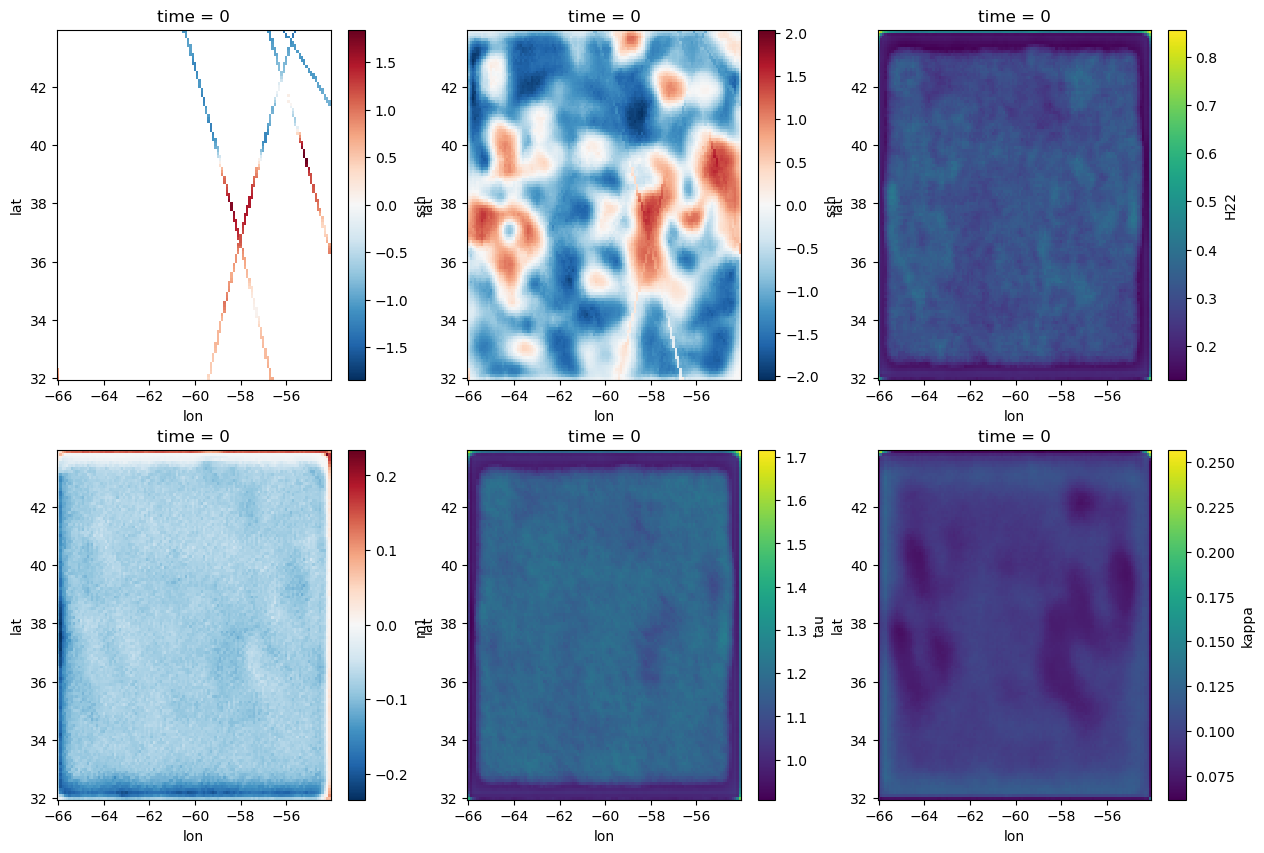

In [9]:
# test
from IPython.display import clear_output
ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2.pth', map_location=device)
solver2.load_state_dict(ckpt)
ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2.pth', map_location=device)
solver.load_state_dict(ckpt)

k = 2
test_batch = next(itertools.islice(datamodule.test_dataloader(), k, None))

test_batch = test_batch._replace(input=test_batch.input.nan_to_num().to(device))
test_batch = test_batch._replace(tgt=test_batch.tgt.nan_to_num().to(device))

out = solver2(test_batch)
mean = up(down(out))
out, theta = solver(crop_batch(test_batch), 
                    x_init=out[:,crop_daw:-crop_daw,:,:].detach(),   
                    mu=mean[:,crop_daw:-crop_daw,:,:].detach())

fig, axs= plt.subplots(2, 3, figsize=(15,10)) 
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),test_batch.tgt[:,idt1,:,:].detach().cpu())},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.isel(time=0).plot(ax=axs[0,0])#(col='time')
xr.Dataset(data_vars={'ssh':(('time','lat','lon'),out[:,idt2,:,:].detach().cpu())},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).ssh.isel(time=0).plot(ax=axs[0,1])#(col='time')
xr.Dataset(data_vars={'H22':(('time','lat','lon'),np.reshape(theta[2][:,1,1,:,idt2].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).H22.isel(time=0).plot(ax=axs[0,2])#(col='time')
xr.Dataset(data_vars={'m1':(('time','lat','lon'),np.reshape(theta[1][:,0,:,idt2].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).m1.isel(time=0).plot(ax=axs[1,0])#(col='time')
xr.Dataset(data_vars={'tau':(('time','lat','lon'),np.reshape(theta[3][:,0,:,idt2].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).tau.isel(time=0).plot(ax=axs[1,1])#(col='time')
xr.Dataset(data_vars={'kappa':(('time','lat','lon'),np.reshape(theta[0][:,0,:,idt2].detach().cpu(),(2,120,120)))},
           coords={'time':np.arange(2),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).kappa.isel(time=0).plot(ax=axs[1,2])#(col='time')
plt.show()

# Run simulations on the test case

In [10]:
from IPython.display import clear_output
from sksparse.cholmod import cholesky
import scipy 

def sparse_torch2scipy(A):
    B = scipy.sparse.csc_matrix((A.coalesce().values(),
                         A.coalesce().indices()),
                         shape=(A.size()[0],A.size()[0]),dtype=np.float64)
    return B

def run_simulation(i,tau,M,x,dx,dy,dt,n_init_run=10):
    nb_nodes = M.shape[0]
    regul = (tau*np.sqrt(dt))/(dx*dy)
    val = cupy.fromDlpack(to_dlpack(M.coalesce().values().data))
    ind = cupy.fromDlpack(to_dlpack(M.coalesce().indices().data))
    M_ = cupy_sp_csc_matrix((val,ind),shape=(M.size()[0],M.size()[0]))
    # if i==0: start stability run
    if i==0:
        xi = torch.randn(nb_nodes).to(device)
        for i in range(n_init_run):
            random = torch.randn(nb_nodes).to(device)
            RM = torch.mul(regul,random)+torch.flatten(xi)
            RM_ = cupy.fromDlpack(to_dlpack(RM))
            xi_ = cupy_spsolve(M_, RM_)
            xi = torch.flatten(from_dlpack(xi_.toDlpack())).to(device)
            #xi = torch.flatten(cupy_solve_sparse.apply(M,RM)).to(device)     
    else:
        random = torch.randn(nb_nodes).to(device)
        RM = torch.mul(regul,random)+torch.flatten(x[i-1])
        RM_ = cupy.fromDlpack(to_dlpack(RM))
        xi_ = cupy_spsolve(M_, RM_)
        xi = torch.flatten(from_dlpack(xi_.toDlpack())).to(device)
        #xi = torch.flatten(cupy_solve_sparse.apply(M,RM)).to(device)
    xi.requires_grad = True
    xi = torch.flatten(xi)
    x.append(xi)
    return x

n_b, n_t, n_y, n_x = out.shape
nb_nodes = n_x*n_y
dx = dy = dt = 1

# run n_simu non-conditional simulation
I = sparse_eye(nb_nodes)

def set_downsamp(nll,dw):
    nll.downsamp = dw
    nll.down = nn.AvgPool2d(nll.downsamp) if nll.downsamp is not None else nn.Identity()
    nll.up = (
            nn.UpsamplingBilinear2d(scale_factor=nll.downsamp)
            if nll.downsamp is not None
            else nn.Identity()
        )
    return nll
        
#solver.nll = set_downsamp(solver.nll,2)
if solver.nll.downsamp is not None:
    spde = Prior_SPDE([n_t,n_y//solver.nll.downsamp,n_x//solver.nll.downsamp],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")    
    theta[0],theta[1],theta[2],theta[3] = solver.nll.downsamp_params(theta[0],theta[1],theta[2],theta[3],
                                                         sp_dims=[n_y, n_x])
else:
    spde = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")
    
Q = spde(theta[0],theta[1],theta[2],theta[3],
         store_block_diag=False)

if solver.nll.downsamp is not None:
    theta[0],theta[1],theta[2],theta[3]  = solver.nll.upsamp_params(theta[0],theta[1],theta[2],theta[3] ,
                                                          sp_dims=[n_y//solver.nll.downsamp, 
                                                                   n_x//solver.nll.downsamp])

n_simu = 2
x_simu = []
type_simu="cov"
for ibatch in range(n_b):
    if type_simu=="seq":
        x_simu_ = []
        for _ in range(n_simu):
            simu = []
            for it in range(n_t):
                # A=solver.nll.operator_spde.fdm(
                A = DiffOperator_old(n_x,
                                     n_y,
                                     dx,
                                     dy,
                                     theta[1][ibatch,:,:,it],
                                     theta[2][ibatch,:,:,:,it],
                                     theta[0][ibatch,:,:,it])
                M = I+pow_diff_operator(A,pow=int(2*pow),sparse=True)
                simu = run_simulation(it,theta[3][ibatch,0,:,it],M,
                                                  simu,dx,dy,dt=1,n_init_run=10)
            x_simu_.append(torch.reshape(torch.stack(simu,dim=0),(n_t,n_y,n_x)))
        x_simu.append(torch.stack(x_simu_,dim=3))      
    else:
        Q_ = Q[ibatch].detach().cpu()
        Q_sp = sparse_torch2scipy(Q_)
        factor = cholesky(Q_sp,ordering_method='natural')
        if solver.nll.downsamp is not None:
            RM = factor.apply_P(torch.randn((nb_nodes//(solver.nll.downsamp**2))*n_t,n_simu))
        else:
            RM = factor.apply_P(torch.randn(nb_nodes*n_t,n_simu))
        x_simu_ = torch.FloatTensor(factor.solve_Lt(RM,
                                                    use_LDLt_decomposition=False)).to(device)
        if solver.nll.downsamp is not None:
            x_simu_ = torch.squeeze(torch.stack([solver.nll.up(torch.reshape(x_simu_[:,i],(1,n_t,n_x//solver.nll.downsamp,n_y//solver.nll.downsamp))) for i in range(n_simu)],dim=4),
                                dim=0)
        else:
            x_simu_ = torch.reshape(x_simu_,(n_t,n_x,n_y,n_simu))
        x_simu.append(x_simu_) 
x_simu = torch.stack(x_simu,dim=0).to(device)

#solver.nll = set_downsamp(solver.nll,None)

# interpolate the simulation based on LSTM-solver
x_simu_cond = []
x_itrp_simu = []
for i in range(n_simu):
    # !! S_NC = out + anomaly 
    inputs_simu = out + x_simu[:,:,:,:,i]
    inputs_obs_simu = out + x_simu[:,:,:,:,i]
    mask = (crop_batch(test_batch).input!=0)
    inputs_obs_simu[~mask] = 0.
    # create simu_batch
    simu_batch = test_batch 
    m_simu, s_simu = torch.nanmean(inputs_simu) , torch.std(inputs_simu)
    simu_batch = simu_batch._replace(input=torch.cat((torch.zeros((n_b,crop_daw, n_y, n_x)).to(device),
                                                      inputs_obs_simu,
                                                      torch.zeros((n_b,crop_daw, n_y, n_x)).to(device)),dim=1))
    simu_batch = simu_batch._replace(tgt=torch.cat((torch.zeros((n_b,crop_daw, n_y, n_x)).to(device),
                                                      inputs_simu,
                                                      torch.zeros((n_b,crop_daw, n_y, n_x)).to(device)),dim=1))
    # itrp non-conditional simulations (solver 2 is enough)
    x_itrp_simu_ = solver2(simu_batch)
    x_itrp_simu_ = x_itrp_simu_[:,crop_daw:-crop_daw,:,:] 
    x_itrp_simu.append(x_itrp_simu_)
    # conditional simulations
    x_simu_cond_ = (simu_batch.tgt[:,crop_daw:-crop_daw,:,:] - x_itrp_simu_) + out
    x_simu_cond.append(x_simu_cond_)
x_itrp_simu = torch.stack(x_itrp_simu,dim=4).to(device)
x_simu_cond = torch.stack(x_simu_cond,dim=4).to(device)

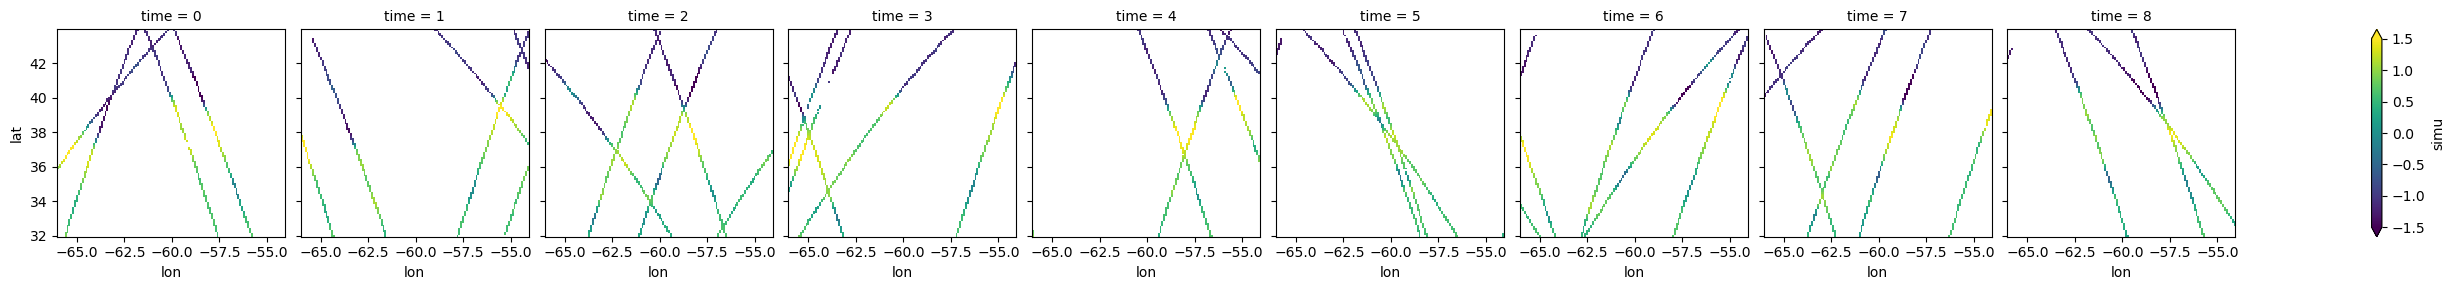

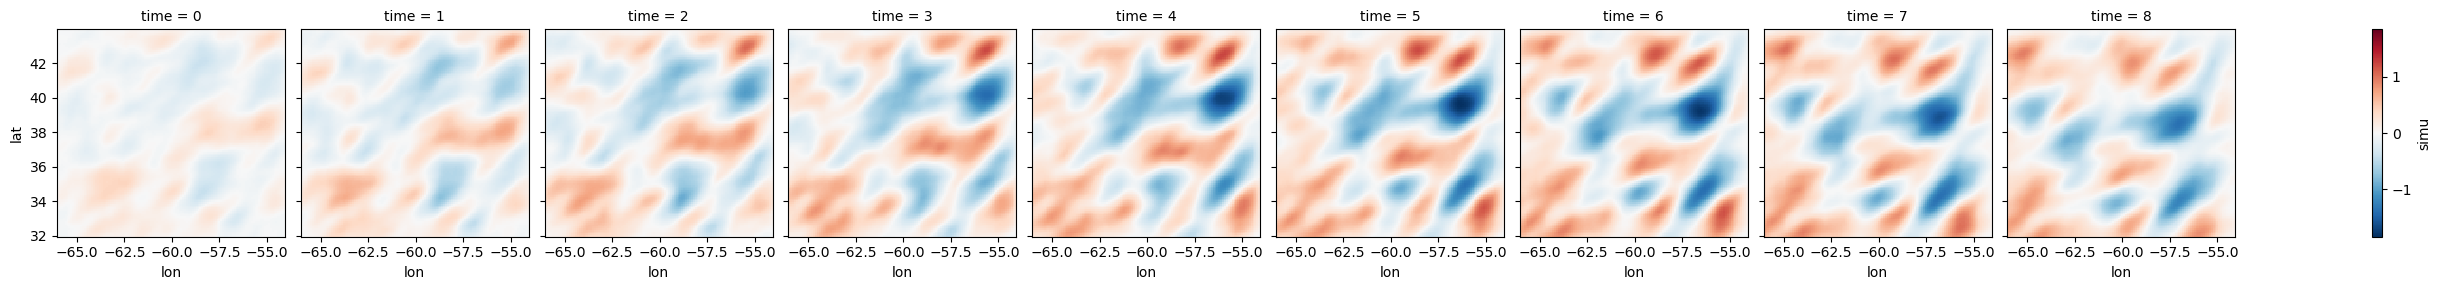

IndexError: index 5 is out of bounds for dimension 4 with size 2

In [11]:
from IPython.display import clear_output

print(theta[3].shape)

# GT
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(test_batch.tgt[:1,crop_daw:-crop_daw,:,:].detach().cpu(),(5,120,120)))},
           coords={'time':np.arange(5),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time')#,vmin=-1.5,vmax=1.5)
clear_output(wait=True)
plt.show()
# xt - x* (in the NLL training loss cost)
xr.Dataset(data_vars={'simu':(('time','lat','lon'),((test_batch.tgt[0,crop_daw:-crop_daw,:,:]-out)[0,:,:,:].detach().cpu()).numpy())},
           coords={'time':np.arange(9-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
# x* - xbar (in the NLL variational cost)
xr.Dataset(data_vars={'simu':(('time','lat','lon'),(out[0,:,:,:].detach().cpu()-up(down(out))[0,:,:,:].detach().cpu()).numpy())},
           coords={'time':np.arange(9-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu[:1,:,:,:,0].detach().cpu(),(9-2*crop_daw,120,120)))},
           coords={'time':np.arange(9-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),(crop_batch(simu_batch).tgt[0,:,:,:]).detach().cpu().numpy())},
           coords={'time':np.arange(9-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_itrp_simu[:1,:,:,:,0].detach().cpu(),(9-2*crop_daw,120,120)))},
           coords={'time':np.arange(9-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time',vmin=-1.5,vmax=1.5)
plt.show()
xr.Dataset(data_vars={'simu':(('time','lat','lon'),np.reshape(x_simu_cond[:1,:,:,:,0].detach().cpu(),(9-2*crop_daw,120,120)))},
           coords={'time':np.arange(9-2*crop_daw),
                   'lon':np.arange(-66, -54, 0.1),
                   'lat':np.arange(32, 44, 0.1)}).simu.plot(col='time')#,vmin=-1.5,vmax=1.5)
plt.show()

# Run test dataset, output NetCDF and metrics

In [12]:
train_data = load_altimetry_data("/DATASET/mbeauchamp/natl_gf_w_5nadirs_swot.nc").sel(time=slice('2013-02-24', '2013-09-30',),
                                                                          lon=slice(lon_min, lon_max,),
                                                                          lat=slice(lat_min, lat_max,))

0/12
1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12


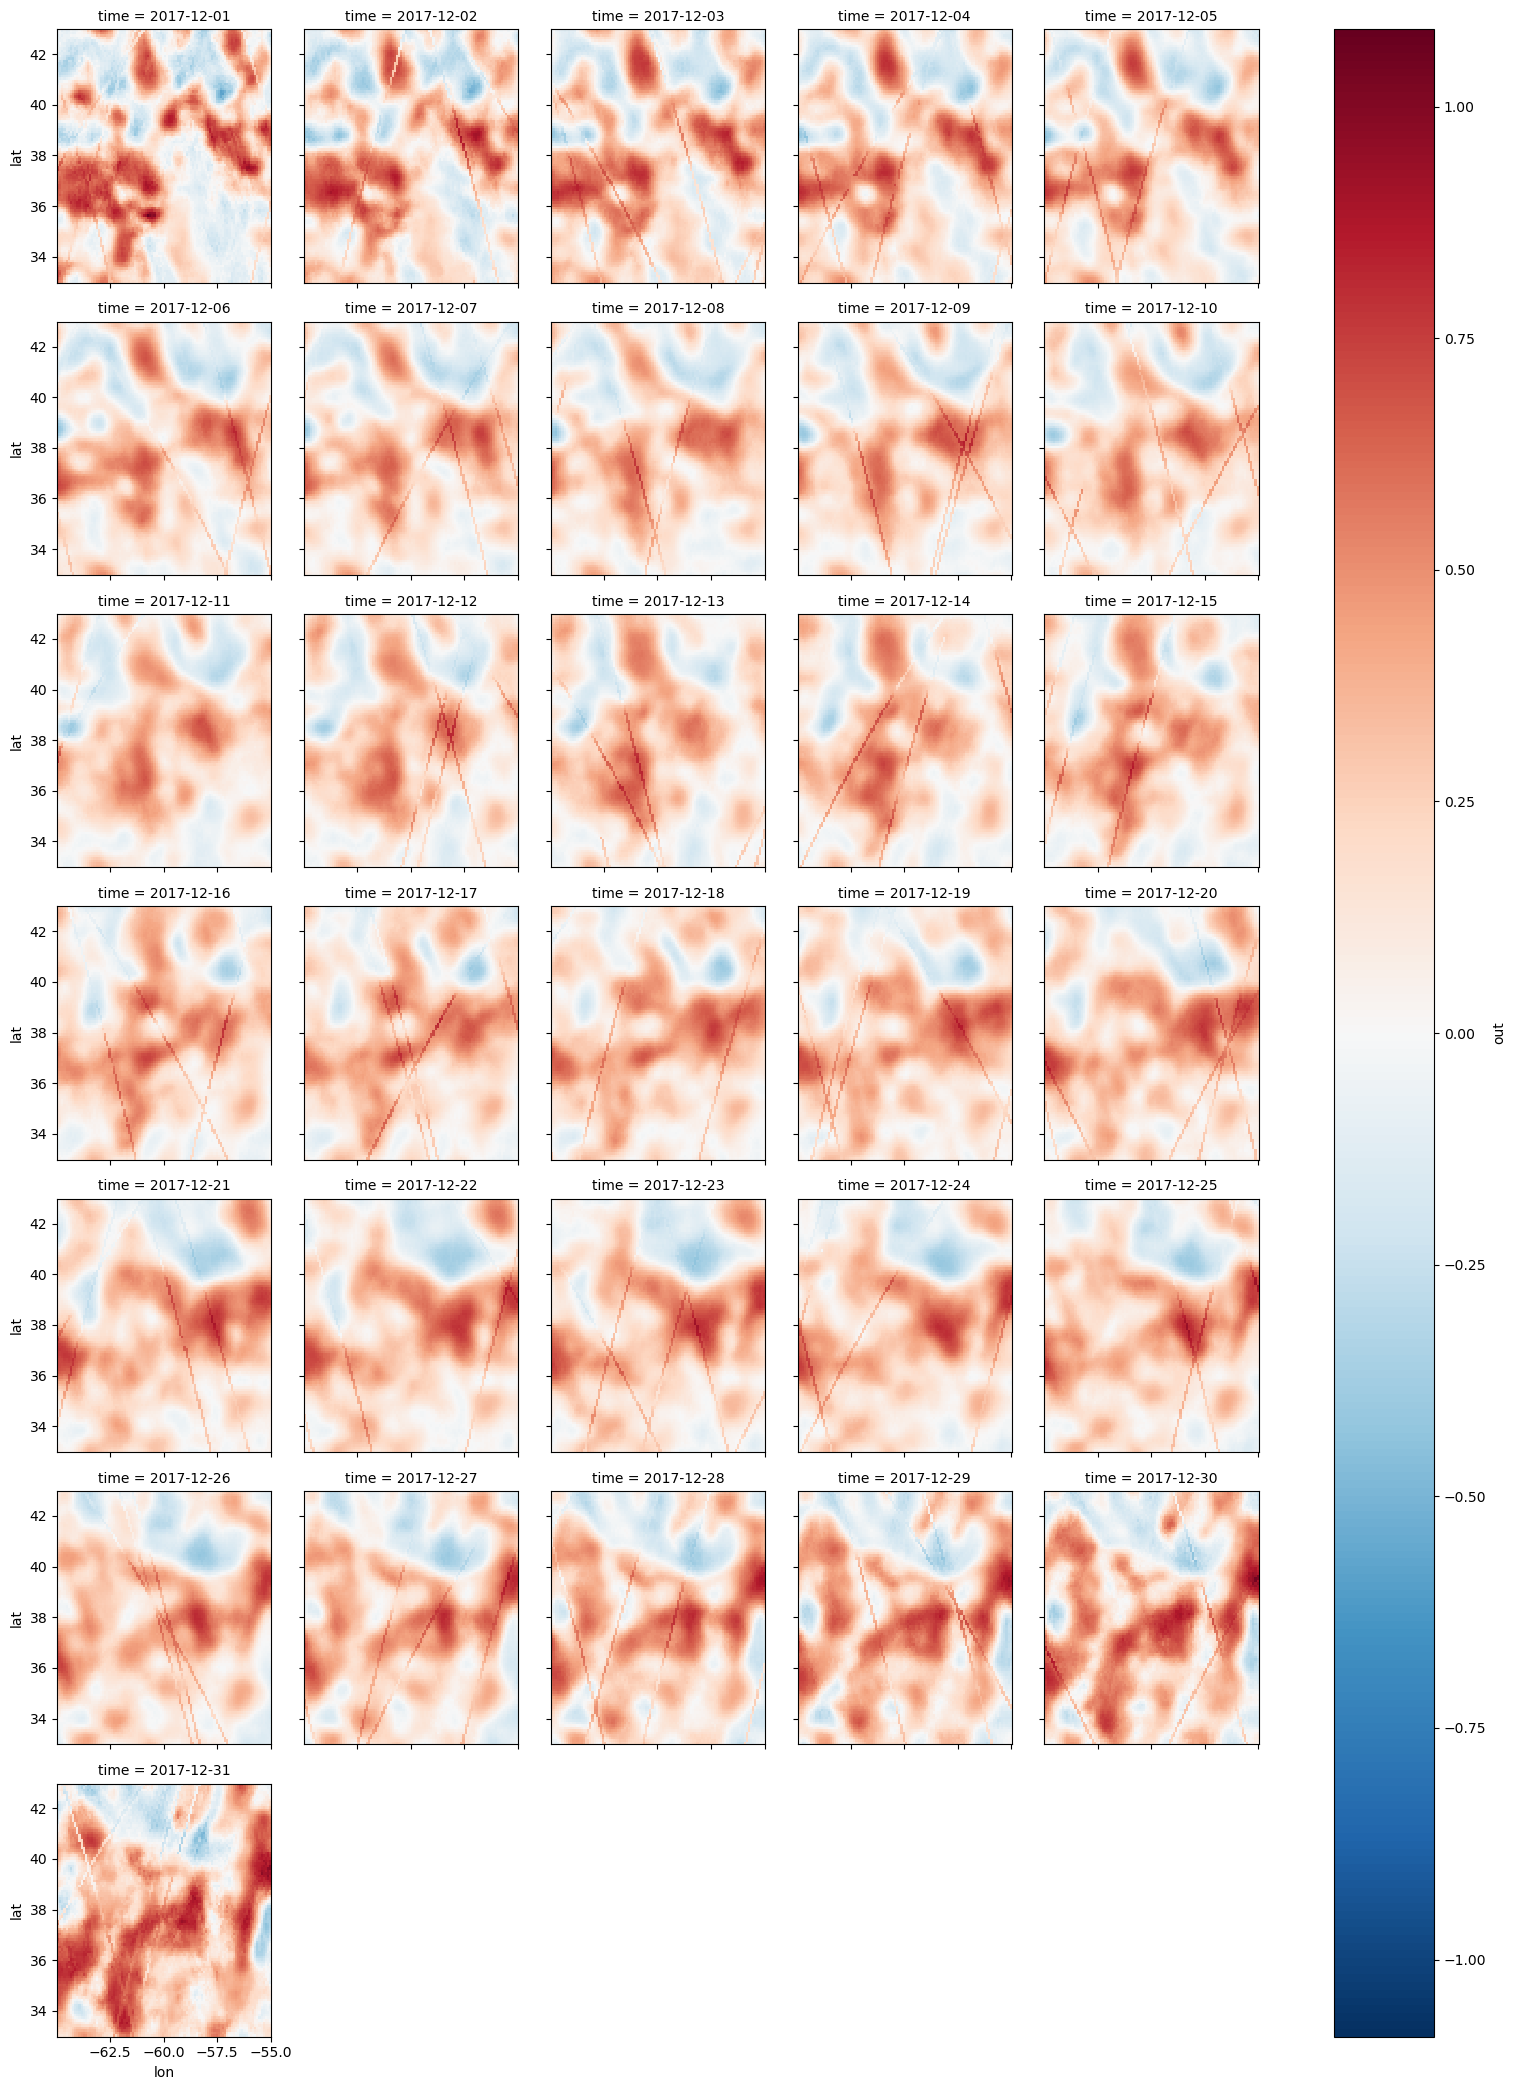

In [13]:
ckpt = torch.load('../ckpt/ckpt_spde_wonll_rzf=2.pth', map_location=device)
solver2.load_state_dict(ckpt)
ckpt = torch.load('../ckpt/ckpt_spde_wnll_rzf=2.pth', map_location=device)
solver.load_state_dict(ckpt)

test_data = []
test_simu = []
test_params = []

test_dataloader = datamodule.test_dataloader()

def test_quantities(self):
    return ['inp', 'tgt', 'out']

def test_simu_quantities(self):
    return ['sample_x', 'mx', 'sample_xy']

def test_params_quantities(self):
        return ['kappa', 'm1', 'm2', 'H11', 'H12', 'H21', 'H22', 'tau']

def norm_stats(train_data, variable='tgt'):
    return train_data.sel(variable=variable).pipe(lambda da: (da.mean().values.item(), da.std().values.item()))

m, s = norm_stats(train_data)


if solver.nll.downsamp is not None:
    spde = Prior_SPDE([n_t,n_y//solver.nll.downsamp,n_x//solver.nll.downsamp],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")    
else:
    spde = Prior_SPDE([n_t,n_y,n_x],st_lag=[1,1,1],
                  pow=solver.nll.pow,spde_type='adv_diff',scheme="FUDM1")    

n_simu = 100
factor = None
for k in range(len(test_dataloader)):
    print(str(k)+'/'+str(len(test_dataloader)))
    test_batch = next(itertools.islice(test_dataloader, k, None))
        
    test_batch_ = test_batch
    test_batch_ = test_batch_._replace(input=test_batch_.input.to(device))
    test_batch_ = test_batch_._replace(tgt=test_batch_.tgt.to(device))
        
    # 4DVarNets scheme  
    out = solver2(test_batch_)
    mean = up(down(out))
    out, theta = solver(crop_batch(test_batch_), 
                    x_init=out[:,crop_daw:-crop_daw,:,:].detach(),   
                    mu=mean[:,crop_daw:-crop_daw,:,:].detach())
        
    n_b, n_t, n_y, n_x = out.shape
    nb_nodes = n_x*n_y
    dx = dy = dt = 1
    
    test_data.append(torch.stack(
        [
            crop_batch(test_batch_).input.cpu() * s + m,
            crop_batch(test_batch_).tgt.cpu() * s + m,
            out.squeeze(dim=-1).detach().cpu() * s + m,
        ],
        dim=1,
    ))
        
    # run n_simu non-conditional simulations
    if solver.nll.downsamp is not None: 
        theta[0],theta[1],theta[2],theta[3] = solver.nll.downsamp_params(theta[0],theta[1],theta[2],theta[3],
                                                         sp_dims=[n_y, n_x])
    Q = spde(theta[0],theta[1],theta[2],theta[3],
             store_block_diag=False)

    x_simu = []
    for ibatch in range(n_b):
        Q_ = Q[ibatch].detach().cpu()
        Q_sp = sparse_torch2scipy(Q_)
        if factor is None:
            factor = cholesky(Q_sp,ordering_method='natural')
        else:
            factor.cholesky_inplace(Q_sp)        
        if solver.nll.downsamp is not None:
            RM = factor.apply_P(torch.randn((nb_nodes//(solver.nll.downsamp**2))*n_t,n_simu))
        else:
            RM = factor.apply_P(torch.randn(nb_nodes*n_t,n_simu))
        x_simu_ = torch.FloatTensor(factor.solve_Lt(RM,
                                                    use_LDLt_decomposition=False)).to(device)
        if solver.nll.downsamp is not None:
            x_simu_ = torch.squeeze(torch.stack([solver.nll.up(torch.reshape(x_simu_[:,i],(1,n_t,n_x//solver.nll.downsamp,n_y//solver.nll.downsamp))) for i in range(n_simu)],dim=4),
                                dim=0)
        else:
            x_simu_ = torch.reshape(x_simu_,(n_t,n_x,n_y,n_simu))
        x_simu.append(x_simu_)
    x_simu = torch.stack(x_simu,dim=0).to(device)

    if solver.nll.downsamp is not None:
        theta[0],theta[1],theta[2],theta[3]  = solver.nll.upsamp_params(theta[0],theta[1],theta[2],theta[3] ,
                                                          sp_dims=[n_y//solver.nll.downsamp, 
                                                                   n_x//solver.nll.downsamp])
    
    # interpolate the simulation based on LSTM-solver
    x_simu_cond = []
    x_simu_itrp = []
    for i in range(n_simu):
        inputs_simu = out + x_simu[:,:,:,:,i]
        inputs_obs_simu = out + x_simu[:,:,:,:,i]
        mask = (crop_batch(test_batch_).input!=0)
        inputs_obs_simu[~mask] = 0.
        # create simu_batch
        simu_batch = test_batch_ 
        simu_batch = simu_batch._replace(input=torch.cat((torch.zeros((n_b,crop_daw, n_y, n_x)).to(device),
                                                       inputs_obs_simu.nan_to_num(),
                                                       torch.zeros((n_b,crop_daw, n_y, n_x)).to(device)),dim=1))
        simu_batch = simu_batch._replace(tgt=torch.cat((torch.zeros((n_b,crop_daw, n_y, n_x)).to(device),
                                                        inputs_simu.nan_to_num(),
                                                       torch.zeros((n_b,crop_daw, n_y, n_x)).to(device)),dim=1))
        # itrp non-conditional simulations (solver 2 is enough)
        x_itrp_simu_ = solver2(simu_batch).detach()
        x_itrp_simu_ = x_itrp_simu_[:,crop_daw:-crop_daw,:,:] 
        x_simu_itrp.append(x_itrp_simu_)
        # conditional simulations
        x_simu_cond_ = (simu_batch.tgt[:,crop_daw:-crop_daw,:,:] - x_itrp_simu_) + out.detach()
        x_simu_cond.append(x_simu_cond_)
    x_simu_itrp = torch.stack(x_simu_itrp,dim=4).to(device).detach().cpu()                
    x_simu_cond = torch.stack(x_simu_cond,dim=4).to(device).detach().cpu() 
        
    test_simu.append(torch.stack(
            [
                x_simu.detach().cpu(),
                x_simu_itrp,
                x_simu_cond * s + m,
            ],
            dim=1,
        ))  
        
    # reshape parameters as maps
    kappa = torch.reshape(theta[0],(len(out),1,n_x,n_y,n_t))
    ma = torch.reshape(theta[1],(len(out),2,n_x,n_y,n_t))
    H = torch.reshape(theta[2],(len(out),2,2,n_x,n_y,n_t))
    tau = torch.reshape(theta[3],(len(out),1,n_x,n_y,n_t))
    kappa = torch.permute(kappa,(0,4,2,3,1))
    kappa = kappa[:,:,:,:,0]
    ma = torch.permute(ma,(0,4,2,3,1))
    m1 = ma[:,:,:,:,0]
    m2 = ma[:,:,:,:,1]
    H = torch.permute(H,(0,5,3,4,1,2))
    H11 = H[:,:,:,:,0,0]
    H12 = H[:,:,:,:,0,1]
    H21 = H[:,:,:,:,1,0]
    H22 = H[:,:,:,:,1,1]
    tau = torch.permute(tau,(0,4,2,3,1))
    tau = tau[:,:,:,:,0]
        
    test_params.append(torch.stack(
            [
                kappa.detach().cpu(),
                m1.detach().cpu(),
                m2.detach().cpu(),
                H11.detach().cpu(),
                H12.detach().cpu(),
                H21.detach().cpu(),
                H22.detach().cpu(),
                tau.detach().cpu()
            ],
            dim=1,
        ))       

# reconstruct mean
if isinstance(test_dataloader,list):
    rec_da = test_dataloader[0].dataset.reconstruct(
            test_data, rec_weight.cpu().numpy(), crop=crop_daw
    )
else:
    rec_da = test_dataloader.dataset.reconstruct(
            test_data, rec_weight.cpu().numpy(), crop=crop_daw
    )
rec_da = test_dataloader.dataset.reconstruct(test_data, rec_weight.cpu().numpy(), crop=crop_daw)
test_data = rec_da.assign_coords(
            dict(v0=test_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

# reconstruct parameters
if isinstance(test_dataloader,list):
    rec_params = test_dataloaders[0].dataset.reconstruct(
            test_params, rec_weight.cpu().numpy(), crop=crop_daw
    )
else:
    rec_params = test_dataloader.dataset.reconstruct(
                test_params, rec_weight.cpu().numpy(), crop=crop_daw
    )
rec_params = test_dataloader.dataset.reconstruct(
                test_params, rec_weight.cpu().numpy(), crop=crop_daw
             )
test_params = rec_params.assign_coords(
            dict(v0=test_params_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

# reconstruct simulations
rec_da_wsimu = []
for i in range(n_simu):
    if isinstance(test_dataloader,list):
        rec_simu = test_dataloader[0].dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    else:
        rec_simu = test_dataloader.dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    rec_simu = test_dataloader.dataset.reconstruct(
            [ts[:,:,:,:,:,i] for ts in test_simu], rec_weight.cpu().numpy(), crop=crop_daw
        )
    rec_da_wsimu.append(rec_simu)
if len(rec_da_wsimu)>1:
    test_simu = xr.concat(rec_da_wsimu, pd.Index(np.arange(n_simu), name='simu'))
else:
    test_simu = rec_da_wsimu[0]
    
test_simu = test_simu.assign_coords(
            dict(v0=test_simu_quantities)
        ).to_dataset(dim='v0').isel(lon=slice(10,110),lat=slice(10,110))

test_data = xr.merge([test_data,test_simu,test_params])
test_data.out.plot(col="time",col_wrap=5)

In [14]:
test_data
c2 = xr.open_dataset("/DATASET/mbeauchamp/natl_ose_6nadirs.nc").sel(time=slice('2017-12-01', '2017-12-31',),
                                                                          lon=slice(lon_min, lon_max,),
                                                                          lat=slice(lat_min, lat_max,))
c2 = c2.coarsen(lon=2,boundary='trim').mean(skipna=True).coarsen(lat=2,boundary='trim').mean(skipna=True)
test_data = test_data.update({'c2':(('time','lat','lon'),c2.c2.values[:,10:110,10:110])})
test_data = test_data.update({'std_simu':(('time','lat','lon'),test_data.sample_xy.std(dim='simu').values)})

-0.4954 0.38354 nan nan


/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/homes/m19beauc/miniconda3/envs/4dvarnet/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


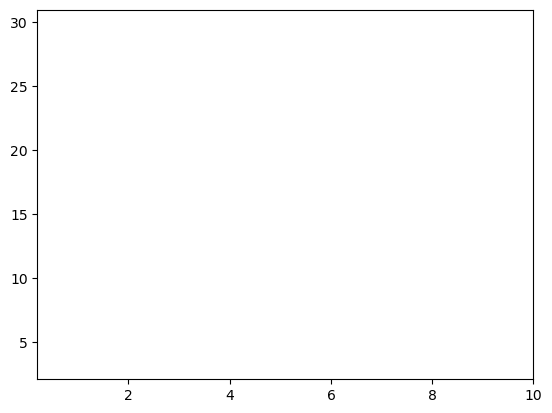

In [15]:
from src.utils import rmse_based_scores_from_ds
from src.utils import psd_based_scores_from_ds
mu, sig = rmse_based_scores_from_ds(test_data, ref_variable='c2', study_variable='out')
lx , lt = psd_based_scores_from_ds(test_data, ref_variable='c2', study_variable='out')
print(mu,sig,lx,lt)

In [16]:
test_data.to_netcdf('xp_ose_rzf2.nc')